In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import missingno as msno 

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
submission = pd.read_csv('./output/sample_submission.csv')

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

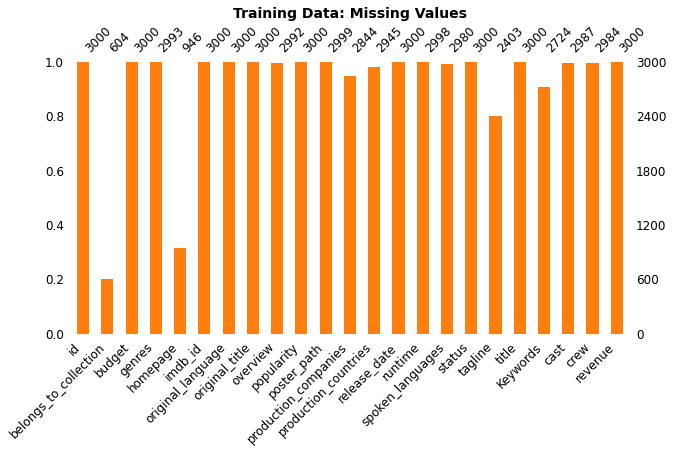

In [6]:
train_miss = msno.bar(train, figsize=(10, 5), fontsize=12, color='C1').set_title('Training Data: Missing Values', fontweight='bold', fontsize=14)

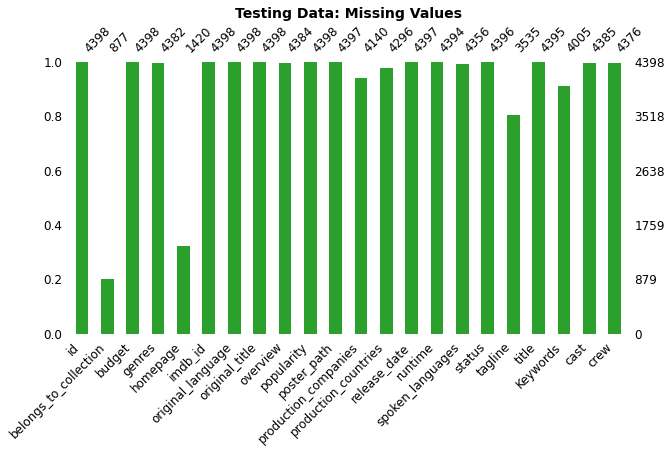

In [8]:
test_miss = msno.bar(test, figsize=(10, 5), fontsize=12, color='C2').set_title('Testing Data: Missing Values', fontweight='bold', fontsize=14)

In [9]:
test[test['release_date'].isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,NaN,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN


In [10]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '5/1/00'
test[test['release_date'] == '5/1/00']

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,5/1/00,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN
1731,4732,NaN,103000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,/6WBIzCgmDCYrqh64yDREGeDk9d3.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",5/1/00,155.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Hero Will Rise.,Gladiator,"[{'id': 588, 'name': 'rome'}, {'id': 1394, 'na...","[{'cast_id': 8, 'character': 'Maximus', 'credi...","[{'credit_id': '52fe4217c3a36847f800340d', 'de..."


In [11]:
train[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = train[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

test[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = test[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

In [12]:
train['runtime'] = train['runtime'].fillna(train['runtime'].mean())
test['runtime'] = test['runtime'].fillna(train['runtime'].mean())
train['runtime'].isnull().any()

False

In [13]:
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')

train["release_year"] = pd.to_datetime(train["release_date"]).dt.year.astype(int)
train["release_day"] = pd.to_datetime(train["release_date"]).dt.dayofweek.astype(int)
train["release_month"] = pd.to_datetime(train["release_date"]).dt.month.astype(int)
test["release_year"] = pd.to_datetime(test["release_date"]).dt.year.astype(int)
test["release_day"] = pd.to_datetime(test["release_date"]).dt.dayofweek.astype(int)
test["release_month"] = pd.to_datetime(test["release_date"]).dt.month.astype(int)

In [14]:
train['release_year'].max()

2068

In [16]:
def fix_date(x):
    if x > 2019:
        return x - 100
    else:
        return x

In [17]:
train['release_year'] = train['release_year'].apply(lambda x: fix_date(x))
test['release_year'] = test['release_year'].apply(lambda x: fix_date(x))